In [346]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, feature_selection, model_selection, ensemble, metrics, linear_model, naive_bayes, naive_bayes
import scipy
import plotly.express as px


In [2]:
train=pd.read_csv('train_sales.csv')
test=pd.read_csv('test_sales.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [4]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [8]:
def isnull(df, features):
    features=[features for features in df.columns if df[features].isnull().sum()>0]
    print(features)
    
    for features in features:
        if df[features].dtype!='O' and features not in 'Item_Identifier':
            print(f'numerical feature: {features}')
            num_null_feats=df[features].isnull().sum()
            print(f'numerical null features: {num_null_feats}')
            
        else:
            print(f'categorical features: {features}')
            print(f'value counts : {df[features].value_counts()}')
            cat_null_feats=df[features].isnull().sum()
            print(f'categorical null features: {cat_null_feats}')

In [9]:
isnull(train, train.columns)

['Item_Weight', 'Outlet_Size']
numerical feature: Item_Weight
numerical null features: 1463
categorical features: Outlet_Size
value counts : Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64
categorical null features: 2410


In [10]:
isnull(test,test.columns)

['Item_Weight', 'Outlet_Size']
numerical feature: Item_Weight
numerical null features: 976
categorical features: Outlet_Size
value counts : Medium    1862
Small     1592
High       621
Name: Outlet_Size, dtype: int64
categorical null features: 1606


In [116]:
def fillna(df, features):
    for features in features:
        null_values=df[features].isnull().sum()
        print(f'features {features} and null values: {null_values} and percentage: {null_values/len(df)}')
        
        if df[features].nunique()>20:
            print(f'the feature {features} is numerical ')
            fig=plt.figure(figsize=(6,4), dpi=100)
            fig,(ax1, ax2)=plt.subplots(1,2)
            df[features].plot.hist(ax=ax1)
            df[features].plot.kde(ax=ax2)
            plt.xlabel(features)
            plt.show()
            
            plt.figure(figsize=(6,4), dpi=100)
            sns.distplot(df[features].dropna())
            plt.xlabel(features)
            plt.show()
            
            df[features+'_medianfill']=df[features].fillna(df[features].median())
            
            plt.figure(figsize=(6,4), dpi=400)
            fig, ((ax1, ax2), (ax3, ax4))=plt.subplots(2,2)
            sns.distplot(df[features+'_medianfill'].dropna(), ax=ax1, axlabel=features)
            sns.distplot(np.log(df[features+'_medianfill'].dropna()), ax=ax2)
            sns.boxplot(df[features].dropna(), ax=ax3)
            sns.boxplot(df[features+'_medianfill'].dropna(), ax=ax4)
            
            plt.xlabel(features+'_medianfill')
            plt.show()
            
        else:
            print(f'the feature {features} is categorical ')
            df[features].value_counts().plot.bar()
            plt.xlabel(features)
            plt.show()
            
            df[features+'_modefill']=df[features].fillna(df[features].mode()[0])
            
            df[features+'_modefill'].value_counts().plot.bar()
            plt.xlabel(features+'_modefill')
            plt.show()
            

features Item_Weight and null values: 1463 and percentage: 0.1716531737651062
the feature Item_Weight is numerical 


<Figure size 600x400 with 0 Axes>

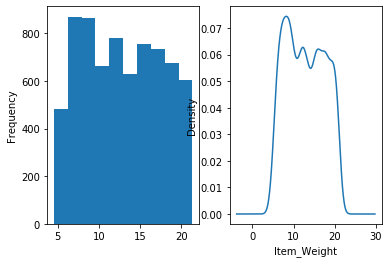

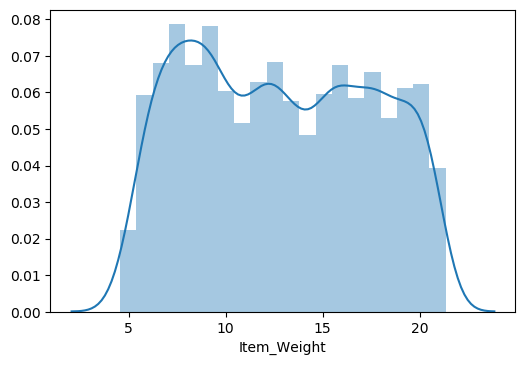

<Figure size 2400x1600 with 0 Axes>

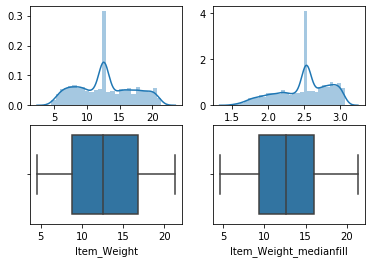

features Outlet_Size and null values: 2410 and percentage: 0.2827642848762173
the feature Outlet_Size is categorical 


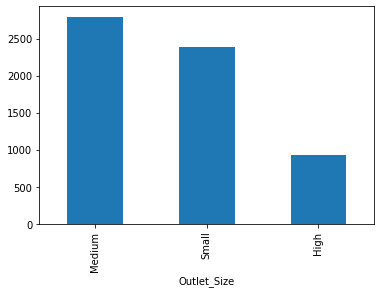

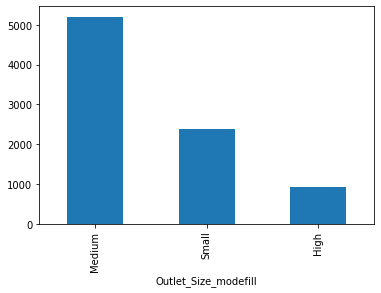

In [117]:
fillna(train, ['Item_Weight', 'Outlet_Size'])

features Item_Weight and null values: 976 and percentage: 0.17180073930646014
the feature Item_Weight is numerical 


<Figure size 600x400 with 0 Axes>

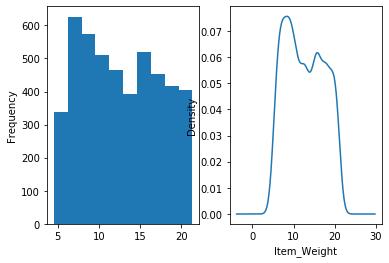

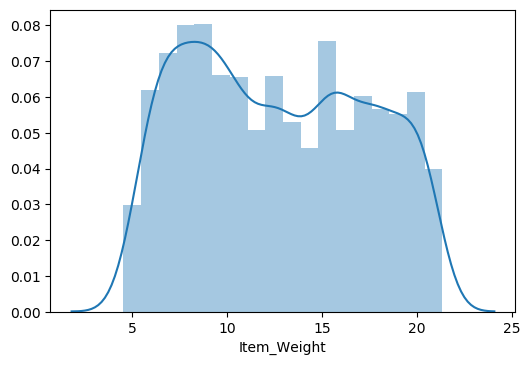

<Figure size 2400x1600 with 0 Axes>

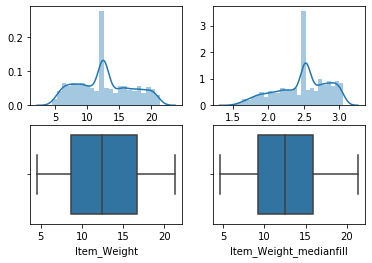

features Outlet_Size and null values: 1606 and percentage: 0.28269670832599897
the feature Outlet_Size is categorical 


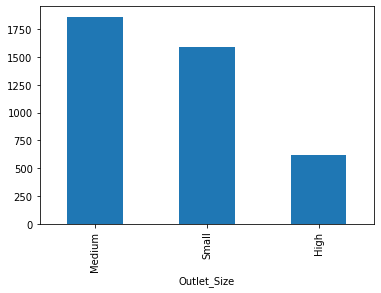

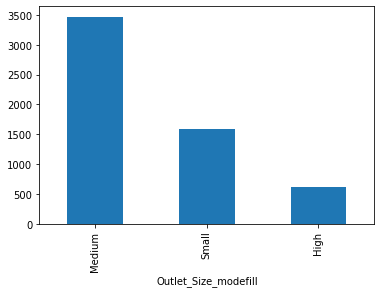

In [321]:
fillna(test, ['Item_Weight', 'Outlet_Size'])

In [141]:
def valueCountsPlot(df, features):
    for features in features:
        if df[features].nunique()<20:
            print(f'feature {features} have value counts: {df[features].value_counts()}')
            df[features].value_counts().plot.bar()
            plt.xlabel(features)
            plt.show()

feature Item_Fat_Content have value counts: Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


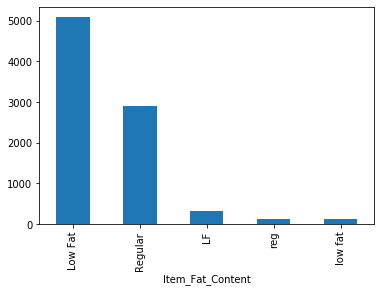

feature Item_Type have value counts: Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


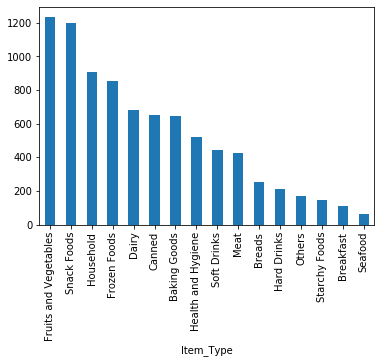

feature Outlet_Identifier have value counts: OUT027    935
OUT013    932
OUT046    930
OUT035    930
OUT049    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64


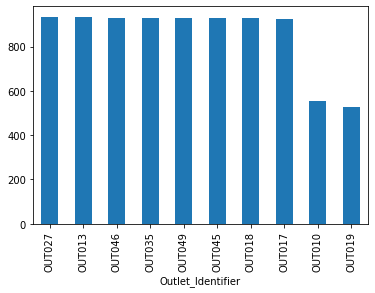

feature Outlet_Establishment_Year have value counts: 1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64


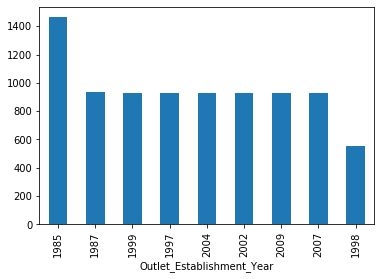

feature Outlet_Size have value counts: Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64


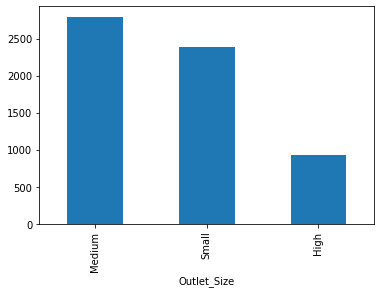

feature Outlet_Location_Type have value counts: Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64


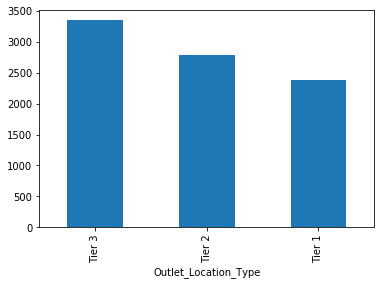

feature Outlet_Type have value counts: Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64


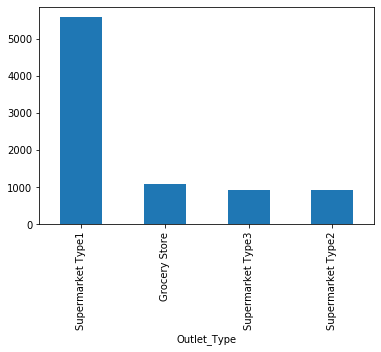

feature Outlet_Size_modefill have value counts: Medium    5203
Small     2388
High       932
Name: Outlet_Size_modefill, dtype: int64


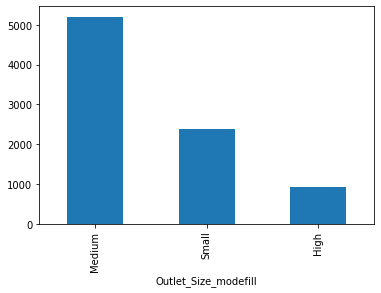

In [142]:
valueCountsPlot(train, train.columns)

In [157]:
def numPlot(df, features):
    for features in features:
        if df[features].nunique()>20 and features not in 'Item_Identifier':
            print(f'numerical feature {features}')
            sns.distplot(df[features].dropna())
            plt.xlabel(features)
            plt.show()

numerical feature Item_Weight


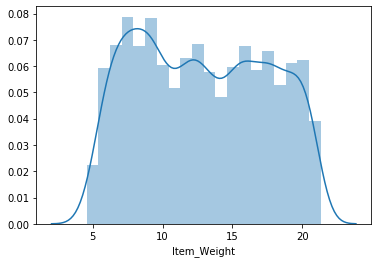

numerical feature Item_Visibility


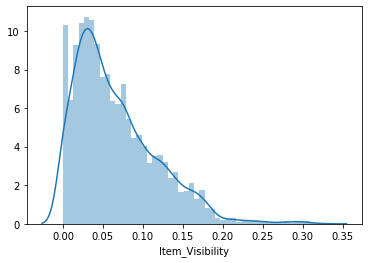

numerical feature Item_MRP


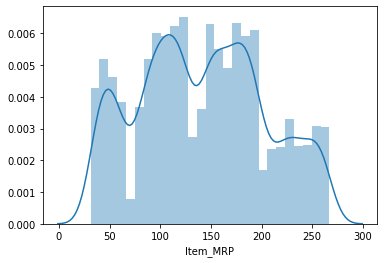

numerical feature Item_Outlet_Sales


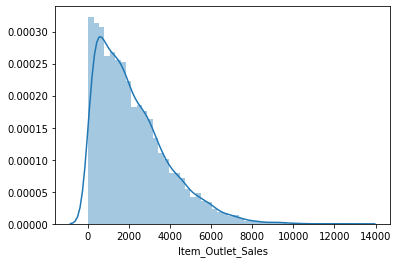

numerical feature Item_Weight_medianfill


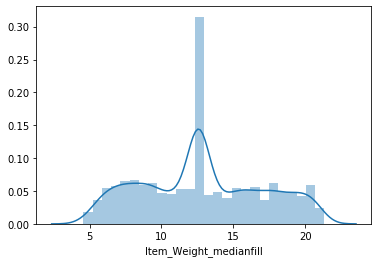

In [158]:
numPlot(train, train.columns)

In [160]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Weight_medianfill
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.00000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914,12.81342
std,4.643456,0.051598,62.275067,8.371760,1706.499616,4.22724
min,4.555000,0.000000,31.290000,1985.000000,33.290000,4.55500
25%,8.773750,0.026989,93.826500,1987.000000,834.247400,9.31000
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000,12.60000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400,16.00000
max,21.350000,0.328391,266.888400,2009.000000,13086.964800,21.35000


In [250]:
def full(df, features):
    for features in features:
        if df[features].nunique()>20 and features not in 'Item_Identifier':
            mean=[df[features].mean()]
            std=[df[features].std()]
            min=[df[features].min()]
            p25=[np.quantile(df[features].dropna(), 0.25)]
            p50=[np.quantile(df[features].dropna(), 0.5)]
            p75=[np.quantile(df[features].dropna(), 0.75)]
            max=[df[features].max()]
            print(f' features {features} has mean value is {mean}')
            print(f' features {features} has std value is {std}')
            print(f' features {features} has min value is {min}')
            print(f' features {features} has 25th percentile value is {p25}')
            print(f' features {features} has 50th percentile value is {p50}')
            print(f' features {features} has 75th percentile value is {p75}')
            print(f' features {features} has maximum value is {max}')
            

In [251]:
full(train, train.columns)

 features Item_Weight has mean value is [12.857645184136183]
 features Item_Weight has std value is [4.643456499186395]
 features Item_Weight has min value is [4.555]
 features Item_Weight has 25th percentile value is [8.77375]
 features Item_Weight has 50th percentile value is [12.6]
 features Item_Weight has 75th percentile value is [16.85]
 features Item_Weight has maximum value is [21.35]
 features Item_Visibility has mean value is [0.06613202877895127]
 features Item_Visibility has std value is [0.051597822321135196]
 features Item_Visibility has min value is [0.0]
 features Item_Visibility has 25th percentile value is [0.026989477499999998]
 features Item_Visibility has 50th percentile value is [0.05393093400000001]
 features Item_Visibility has 75th percentile value is [0.0945852925]
 features Item_Visibility has maximum value is [0.328390948]
 features Item_MRP has mean value is [140.9927819781768]
 features Item_MRP has std value is [62.27506651219039]
 features Item_MRP has m

In [257]:
for features in train.columns:
    if train[features].nunique()<10:
        print(features, train[features].unique())

Item_Fat_Content ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
Outlet_Establishment_Year [1999 2009 1998 1987 1985 2002 2007 1997 2004]
Outlet_Size ['Medium' nan 'High' 'Small']
Outlet_Location_Type ['Tier 1' 'Tier 3' 'Tier 2']
Outlet_Type ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']
Outlet_Size_modefill ['Medium' 'High' 'Small']


In [323]:
train['Item_Fat_Content']=train['Item_Fat_Content'].replace({'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'})
test['Item_Fat_Content']=test['Item_Fat_Content'].replace({'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'})

In [273]:
train

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Weight_medianfill,Outlet_Size_modefill
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,9.300,Medium
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,5.920,Medium
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,17.500,Medium
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,19.200,Medium
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,8.930,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834,6.865,High
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850,8.380,Medium
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136,10.600,Small
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976,7.210,Medium


In [286]:
train.groupby('Item_Type')['Item_Outlet_Sales'].sum()

Item_Type
Baking Goods             1.265525e+06
Breads                   5.532372e+05
Breakfast                2.322990e+05
Canned                   1.444151e+06
Dairy                    1.522594e+06
Frozen Foods             1.825735e+06
Fruits and Vegetables    2.820060e+06
Hard Drinks              4.577934e+05
Health and Hygiene       1.045200e+06
Household                2.055494e+06
Meat                     9.175656e+05
Others                   3.255176e+05
Seafood                  1.488682e+05
Snack Foods              2.732786e+06
Soft Drinks              8.928977e+05
Starchy Foods            3.514013e+05
Name: Item_Outlet_Sales, dtype: float64

In [301]:
def encoding(df, features):
    for features in features:
        if df[features].nunique()<20 and df[features].isnull().sum()==0:
            df[features]=preprocessing.LabelEncoder().fit_transform(df[features])            

In [324]:
encoding(train, train.columns)
encoding(test, test.columns)

In [316]:
finalFeatures=[features for features in train.columns if train[features].dtypes!='O' and features not in 'Item_Identifier' and train[features].isnull().sum()==0]
print(f' final features {finalFeatures}\n\n  length {len(finalFeatures)}' )

 final features ['Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales', 'Item_Weight_medianfill', 'Outlet_Size_modefill']

  length 11


In [335]:
X=train[finalFeatures].drop('Item_Outlet_Sales', axis=1)
x=test[X.columns]
y=train.Item_Outlet_Sales

In [336]:
def train_val_split(X,y):
    global X_train, X_val, y_train, y_val
    X_train, X_val, y_train, y_val=model_selection.train_test_split(X,y, test_size=0.2, random_state=0)

In [337]:
train_val_split(X,y)

In [338]:
def modelPredict(model, X_train, y_train):
    model.fit(X_train, y_train)
    print(f'train score:{model.score(X_train, y_train)}')
    print(f'val score: {model.score(X_val, y_val)}')
    print(f'mean absolute error train: {metrics.mean_absolute_error(y_train, model.predict(X_train))}')
    print(f'mean absolute error val: {metrics.mean_absolute_error(y_val, model.predict(X_val))}')
    print(f'mean squared error train: {metrics.mean_squared_error(y_train, model.predict(X_train))}')
    print(f'mean squared error val: {metrics.mean_squared_error(y_val, model.predict(X_val))}')
    print(f'median absolute error train: {metrics.median_absolute_error(y_train, model.predict(X_train))}')
    print(f'median absolute error val: {metrics.median_absolute_error(y_val, model.predict(X_val))}')
    
    print(f'Prediction test: {model.predict(x)}')

In [339]:
modelPredict(linear_model.LinearRegression(), X_train, y_train)

train score:0.5096042493622123
val score: 0.5130902891731268
mean absolute error train: 893.6418080974624
mean absolute error val: 910.136623745087
mean squared error train: 1426074.3831584458
mean squared error val: 1425116.2898151116
median absolute error train: 685.2323125154925
median absolute error val: 727.5418206880097
Prediction test: [2111.18733073 1181.01637735 2206.67359668 ... 1866.02665686 3200.54697663
 1260.67869656]


In [343]:
modelPredict(linear_model.Ridge(), X_train, y_train)

train score:0.5095990472438092
val score: 0.5130952174804692
mean absolute error train: 893.6576988326764
mean absolute error val: 910.0917535910918
mean squared error train: 1426089.5109563174
mean squared error val: 1425101.8653521799
median absolute error train: 686.0678330202052
median absolute error val: 727.5699274590609
Prediction test: [2107.70576412 1177.93326648 2208.48182624 ... 1867.6683542  3194.5306574
 1264.21753632]


In [344]:
modelPredict(linear_model.Lasso(), X_train, y_train)

train score:0.5094610018524677
val score: 0.5129820806849363
mean absolute error train: 893.8641975044995
mean absolute error val: 910.0862962649165
mean squared error train: 1426490.9479509268
mean squared error val: 1425433.0008516496
median absolute error train: 686.1095035185662
median absolute error val: 723.2224108104056
Prediction test: [2090.06191812 1156.95503317 2223.9866433  ... 1877.27895382 3162.14896205
 1277.86347807]


In [380]:
def transform(X, x):
    global Xs, xs, Xmin, xmin
    Xs=preprocessing.StandardScaler().fit_transform(X)
    xs=preprocessing.StandardScaler().fit_transform(x)
    Xmin=preprocessing.MinMaxScaler().fit_transform(X)
    xmin=preprocessing.MinMaxScaler().fit_transform(x)

    print(Xs)

In [381]:
transform(X,x)

[[-0.73814723 -0.97073217 -0.76647929 ... -0.25265831 -0.83118663
  -0.28458121]
 [ 1.35474328 -0.90811123  1.6089627  ...  1.00297245 -1.63080955
  -0.28458121]
 [-0.73814723 -0.95691733  0.6587859  ... -0.25265831  1.10872696
  -0.28458121]
 ...
 [-0.73814723 -0.59978449  0.1836975  ... -0.25265831 -0.52363935
   1.38127431]
 [ 1.35474328  1.53287976  1.3714185  ...  1.00297245 -1.32562802
  -0.28458121]
 [-0.73814723 -0.41193591  1.6089627  ... -0.25265831  0.46997492
   1.38127431]]


In [382]:
train_val_split(Xmin, y)

In [383]:
modelPredict(linear_model.LinearRegression(),X_train, y_train)

train score:0.5096042493622123
val score: 0.5130902891731273
mean absolute error train: 893.6418080974621
mean absolute error val: 910.1366237450844
mean squared error train: 1426074.3831584458
mean squared error val: 1425116.2898151102
median absolute error train: 685.2323125155311
median absolute error val: 727.5418206879647
Prediction test: [401358.71129024 322320.82309204 883528.76665289 ... 439991.74533925
 788423.07915672 297326.33462295]


In [384]:
modelPredict(linear_model.Ridge(),X_train, y_train)

train score:0.5096008747353244
val score: 0.5130625200609962
mean absolute error train: 893.5014198466934
mean absolute error val: 910.0845715573
mean squared error train: 1426084.1965977978
mean squared error val: 1425197.5661034482
median absolute error train: 684.2194155899962
median absolute error val: 726.5016160496955
Prediction test: [400599.6345382  321659.75825089 881691.26495341 ... 439137.54696717
 786782.82048719 296771.14111885]
